# Fire Detection Using Faster R-CNN

# Paper Referred

https://arxiv.org/pdf/1506.01497.pdf

### Github Repository
https://github.com/pytorch/vision/tree/master/references/detection

### Faster R-CNN Tutorial from
https://www.telesens.co/2018/03/11/object-detection-and-classification-using-r-cnns/

https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

https://www.kaggle.com/moekhan/pytorch-starter-fasterrcnn-train/edit

https://blog.francium.tech/object-detection-with-faster-rcnn-bc2e4295bf49

https://github.com/pytorch/vision/blob/master/torchvision/models/detection/faster_rcnn.py

# Labelling Tools used
https://github.com/tzutalin/labelImg

# Neural Network Traing Strategy
http://karpathy.github.io/2019/04/25/recipe/





In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Calling Libraries

In [2]:
# clone the torchvision libraries
%%shell
# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../


Cloning into 'vision'...
remote: Enumerating objects: 35480, done.
remote: Counting objects: 100% (475/475), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 35480 (delta 353), reused 319 (delta 240), pack-reused 35005
Receiving objects: 100% (35480/35480), 47.69 MiB | 14.71 MiB/s, done.
Resolving deltas: 100% (27203/27203), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


In [2]:
# Calling all the libraries
import numpy as np
import pandas as pd
import torch
import torchvision 
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import  FastRCNNPredictor

from torchvision.models.detection.rpn import AnchorGenerator
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from engine import train_one_epoch, evaluate

import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os, sys, shutil, time 


torch.manual_seed(42)


In [3]:
# install specific pytorch - pytorch==1.3.1 torchvision==0.4.2
!python --version
print(torch.__version__) # 1.1.0
print(torchvision.__version__) #0.2.2


Python 3.7.11
1.9.0+cu102
0.10.0+cu102


In [4]:
# !pip install albumentations==0.4.6
# !pip install -U albumentations
!pip install --upgrade --force-reinstall --no-deps albumentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2 

# https://github.com/albumentations-team/albumentations/blob/master/albumentations/pytorch/transforms.py#L74



  Using cached albumentations-1.0.3-py3-none-any.whl (98 kB)
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.0.3
    Uninstalling albumentations-1.0.3:
      Successfully uninstalled albumentations-1.0.3


In [5]:
# checking for cuda
if (torch.cuda.is_available()):
    device = torch.device('cuda')
    print(f'device is {device} and device name is {torch.cuda.get_device_name(0)}')
else:
    device = torch.device('cpu')
    print(f'Connected to {str(device).upper()}')


device is cuda and device name is Tesla P100-PCIE-16GB


In [6]:
!nvidia-smi

Wed Aug 25 00:30:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
torch.cuda.memory_summary(device= None, abbreviated= False)


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

In [8]:
# Root directory for the project
ROOT_DIR = '/content/drive/MyDrive/Data_Science/projects/Fire_Detection_System/'
# ROOT_DIR = '/content/drive/MyDrive/Data_Science/projects/Fire_Detection_System/data_10files'

# to find local version of the library
sys.path.append(ROOT_DIR)

# train and test dir
TRAIN_DIR = os.path.join(ROOT_DIR, 'data/train/')
TEST_DIR  = os.path.join(ROOT_DIR, 'data/validation/')



# Dataset

In [9]:
# copy google drive files to colab directories

# start = time.time()
# if os.path.exists('/content/data/'):
#     shutil.rmtree('/content/data/')



# !rm -r /content/data/
# !cp -r /content/drive/MyDrive/Data_Science/projects/Fire_Detection_System/data/ .
# end = time.time()
# print(f'\nTotal time to transfer data is {end-start}  seconds\n')

# main_dir = '/content/drive/MyDrive/Data_Science/projects/Fire_Detection_System'
# train_dir = '/content/data/train/images/'
# test_dir  = '/content/data/validation/images/'

#load csv with bounding details into pandas
train_df = pd.read_csv(os.path.join(TRAIN_DIR,'myvisionai_7_24_21_tr.csv'))
test_df = pd.read_csv(os.path.join(TEST_DIR, 'myvisionai_7_24_21_val.csv'))

# print(f"Unique pics in train are {len(train_df['filename'].unique())}")
print(train_df.info(), "\n\n")

# print(f"Unique pics in test are {len(test_df['filename'].unique())}")
print(test_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 563 entries, 0 to 562
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  563 non-null    object
 1   width     563 non-null    object
 2   height    563 non-null    object
 3   class     563 non-null    object
 4   xmin      563 non-null    int64 
 5   ymin      563 non-null    int64 
 6   xmax      563 non-null    int64 
 7   ymax      563 non-null    int64 
dtypes: int64(4), object(4)
memory usage: 35.3+ KB
None 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  138 non-null    object
 1   width     138 non-null    object
 2   height    138 non-null    object
 3   class     138 non-null    object
 4   xmin      138 non-null    int64 
 5   ymin      138 non-null    int64 
 6   xmax      138 non-null    int64 
 7   ymax  

In [10]:
train_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,img (31).jpg,295,171,fire,5,40,81,95
1,img (32).jpg,undefined,undefined,fire,63,107,150,166
2,img (33).jpg,undefined,undefined,fire,153,114,218,153
3,img (34).jpg,undefined,undefined,fire,135,87,197,145
4,img (35).jpg,undefined,undefined,fire,206,11,288,73


In [11]:
# change xmin, ymin, xmax, and ymax as float
train_df['xmin'] = train_df['xmin'].astype(np.float)
train_df['xmax'] = train_df['xmax'].astype(np.float)
train_df['ymin'] = train_df['ymin'].astype(np.float)
train_df['ymax'] = train_df['ymax'].astype(np.float)

test_df['xmin'] = test_df['xmin'].astype(np.float)
test_df['xmax'] = test_df['xmax'].astype(np.float)
test_df['ymin'] = test_df['ymin'].astype(np.float)
test_df['ymax'] = test_df['ymax'].astype(np.float)

In [ ]:
# checking number of files in train and test
for path, dir, fils in os.walk(os.path.join(TRAIN_DIR, 'images/')):
    print(f'{path} has {len(os.listdir(path))}')

for path, dir, fils in os.walk(os.path.join(TEST_DIR, 'images/')):
    print(f'{path} has {len(os.listdir(path))}')


/content/drive/MyDrive/Data_Science/projects/Fire_Detection_System/data/train/images/ has 412
/content/drive/MyDrive/Data_Science/projects/Fire_Detection_System/data/validation/images/ has 90


In [ ]:
TRAIN_DIR

'/content/drive/MyDrive/Data_Science/projects/Fire_Detection_System/data/train/'

Image size is (191, 264, 3)


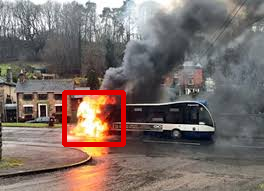

In [ ]:
#plot a picture
pic_name = 'img (115).jpg' #'Fire_36.jpg'
image = cv2.imread(os.path.join(TRAIN_DIR, 'images', pic_name)) # 'images', pic_name))
print(f'Image size is {image.shape}')

xmin = train_df[train_df['filename']== pic_name]['xmin'].values
ymin = train_df[train_df['filename']== pic_name]['ymin'].values
xmax = train_df[train_df['filename']== pic_name]['xmax'].values
ymax = train_df[train_df['filename']== pic_name]['ymax'].values

from google.colab.patches import cv2_imshow # https://github.com/jupyter/notebook/issues/3935
image = cv2.rectangle(image, (xmin,ymin), (xmax, ymax), color=(0,0,225 ), thickness=3)
cv2_imshow(image)


In [ ]:
xmin

array([64.])

In [ ]:
# Creating FireDataseet class
class FireDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms= None):
        super().__init__()

        self.df = dataframe
        self.image_dir = image_dir
        self.image_ids = dataframe['filename'].unique()
        # print(f'self.image_ids is {self.image_ids.shape}')
        # print('new dir is',self.image_dir)
        self.transforms = transforms

    def __getitem__(self, index: int):
        # print(f'index is {index} and image_id is {self.image_ids[index]}')
        image_id = self.image_ids[index]
        records = self.df[self.df['filename'] == image_id]

        # read image into cv2 format
        # image = Image.open(os.path.join(self.image_dir, image)).convert("RGB")
        
        image = cv2.imread(os.path.join(self.image_dir, image_id), cv2.IMREAD_COLOR)#Image.open
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /=  255.
        # print(f'image_dir is {self.image_dir}')#, image shape is {image.shape}, \n ')
       

        # find are based on xmin, ymin, xman, and yman
        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
        
        # print(f'boxes is {boxes}')
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        
        # print(f'area is {area}')

        # conver boxes and are into tensors
        
        # boxes = torch.as_tensor(boxes, dtype= torch.float32)
        
        area  = torch.as_tensor(area, dtype=torch.float32)

        # there is one class only
        iscrowd = torch.zeros((boxes.shape[0], ), dtype=torch.int64)
        # print('here')
        labels = torch.ones((boxes.shape[0], ), dtype=torch.int64)
       

        # create a dictionary target
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd
        # print('there')

        # # transforms
        if self.transforms is not None:
            # image = self.transforms(image)
            sample = {'image': image,
                      'bboxes': target['boxes'],
                      'labels': labels
                      }
            sample = self.transforms(**sample)
            image = sample['image']
        
        # zip boxes, map as tensor, create tuple and stack
        target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target

    def __len__(self) -> int:
        return self.image_ids.shape[0]
        # return 10 # returns only 10 images - use it for overfitting the model



In [ ]:
# Instead of transform running Albumentations

def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)], # P(prob/apply aug) = 0.1, numpy HWC -> tensor CHW
    bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_test_transform():
    return A.Compose([
        ToTensorV2(p=1.0)], 
    bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})



In [ ]:
# https://www.kaggle.com/moekhan/pytorch-starter-fasterrcnn-train/edit

class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property # decorator same as property method
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total /self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [ ]:

batch_size = 4
img_size = 100
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# collate function
# each element of dataset returns tupe(image, target) instead of a single value

def collate_function(batch):
    return tuple(zip(*batch))

# def get_transform(train):
#     transforms = []
#     # transforms.append(T.Resize(img_size)) # resize to avoid insufficient memory
#     # transforms.append(T.CenterCrop(img_size))
#     # conver PIL to Tensor
#     transforms.append(T.ToTensor())
#     if train:
#         # flip images during training 
#         transforms.append(T.RandomHorizontalFlip(0.5))
#     return T.Compose(transforms)

# train and test datasets
train_dataset = FireDataset(train_df, os.path.join(TRAIN_DIR, 'images'), get_train_transform() )
test_dataset  = FireDataset(test_df, os.path.join(TEST_DIR, 'images'), get_test_transform() )
# train_dataset = FireDataset(train_df, TRAIN_DIR, get_train_transform() )



#train and test dataloader
train_data_loader = DataLoader(train_dataset,
                               batch_size=batch_size,
                               shuffle=True,
                               num_workers =2,
                               collate_fn = collate_function)

test_data_loader = DataLoader(test_dataset,
                               batch_size=batch_size,
                               shuffle=False,
                               num_workers =2,
                               collate_fn = collate_function)


In [ ]:
for images, targets in train_data_loader:
    break
print(f"image_0 is {images[0].shape}")
# print(f'image_1 is {images[1].shape}')
print(f'targets_0 are {targets[0]}')
# print(f'targets_1 are {targets[1]}\n\n')

image_0 is torch.Size([3, 183, 275])
targets_0 are {'boxes': tensor([[ 83.0000,  66.0000, 164.0000, 149.0000]], dtype=torch.float64), 'labels': tensor([1]), 'image_id': tensor([268]), 'area': tensor([6723.]), 'iscrowd': tensor([0])}


In [ ]:
# def image_convert(image):
#     image = image.clone().cpu().numpy()
#     image = image.transpose((1, 2, 0))
#     image = (image * 255).astype(np.uint8)
#     return image

# def plot_image(data, idx):
#     out = data.__getitem__(idx)
#     print(f"image.shape is {out[0].shape}") #torch.Size([3, 183, 275])
#     image = image_convert(out[0])
#     image = np.ascontiguousarray(image) # returns ndarray contiguous
#     bb = out[1]['boxes'].numpy()
#     for i in bb:
#         cv2.rectangle(image, (i[0], i[1]), (i[2], i[3]), (225, 0 ,0), thickness=2)
    
#     plt.figure(figsize=(10,10))
#     plt.imshow(image)

# plot_image(train_dataset, 9)


img has shape of (183, 275, 3)
boxes is [[ 85  14 211 100]]
dimension of boxeses  are 85, 14, 211, 100


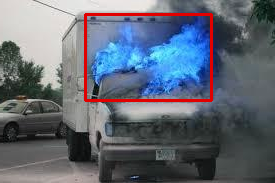

In [ ]:
# let's see some images
# read first batch from train_data_loader
images, targets = next(iter(train_data_loader))

#send image to device
images = list(image.to(device) for image in images)

# targets = [{k: v.to(device) for k,v in t.items()} for t in targets]
targets = [{k: v.long().to(device) for k,v in t.items()} for t in targets]

boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
xmin, ymin, xmax, ymax = boxes[0][0], boxes[0][1],boxes[0][2], boxes[0][3]

sample_tr = images[0].permute(1, 2, 0).cpu().numpy() # permute rearrange to 1,2,0 axis

# de-normalize
sample_tr = sample_tr *  255.

print(f"img has shape of {sample_tr.shape}")
print(f"boxes is {boxes}")
print(f"dimension of boxeses  are {xmin}, {ymin}, {xmax}, {ymax}")


# fig, ax = plt.subplots(1, 1, figsize=(10,8))

for box in boxes:
    cv2.rectangle(sample_tr,
                 (box[0], box[1]),
                 (box[2], box[3]), 
                # (5, 40), (81, 95),
                  color=(0, 0, 225),
                  thickness=2)

# for i in range(len(boxes)):
#     cv2.rectangle(sample_tr, 
#                   (boxes[i][0], boxes[i][1]),
#                   (boxes[i][2], boxes[i][3]),
#                   (0, 0 , 225), 3)


# ax.set_axis_off()
# ax.imshow(sample_tr)  #works but no bounding boxes

from google.colab.patches import cv2_imshow # https://github.com/jupyter/notebook/issues/3935
# sample_tr = cv2.rectangle(sample_tr, (xmin, ymin), (xmax, ymax), (0,0,225 ), 2)
cv2_imshow(sample_tr); # blank screen - nothing display



# Pre-trained Model from torchvision


In [ ]:
#Fine Tuning Pre-Trained Model
#load a pre-trained model with resnet50 as backbone
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one
num_classes = 2 # 1 class(fire) and 0(background)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head wit the new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)



# Train

In [ ]:
# Training parameters
num_epochs = 30 #100
learning_rate = 1e-4
loss_hist = Averager()

model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr = 0.005, momentum = 0.9, weight_decay= 0.005)
# lr_scheduler = None

# USE ADAM
optimizer = torch.optim.Adam(params= params, lr = learning_rate)

start_time = time.time()
total_train_loss = []

for epoch in range(num_epochs):
    loss_hist.reset()
    star_time = time.time()
    train_loss = []
    model.train()

    for images, targets in train_data_loader:
        
        #send images and targets to device
        images = list(image.to(device) for image in images)
        # targets = [{k: v.to(device) for k,v in t.items()} for t in targets]
        targets = [{k: v.long().to(device) for k,v in t.items()} for t in targets]


        loss_dict = model(images, targets)
        # print(f'loss dict is {loss_dict}')
        losses = sum(loss for loss in loss_dict.values())
        # print(f'diff losses are {loss_dict.keys()} ')
        train_loss.append(losses.item())
        # print(f"train losss is {train_loss}")
        loss_hist.send(losses.item())

        optimizer.zero_grad() # to clear old gradient to zero
        losses.backward() # back prop for required_grade = True
        optimizer.step() # update parameter based on parameter.grad

    epoch_train_loss = np.mean(train_loss)
    # print(f"Epoch_train_loss is {epoch_train_loss}")
    total_train_loss.append(epoch_train_loss)
        
        #     print(f'Iterattion #{iter}  loss: {loss_value}')

        # itr += 1
        # if lr_scheduler is not None:
        #     lr_scheduler.step() # for adjusting the learning rate

    # print(f'Epoch #{epoch+1} loss: {epoch_train_loss}')
    print(f'Epoch #{epoch+1} loss: {loss_hist.value}')


    evaluate(model, test_data_loader, device=device )

# save check points at every epochs

end_time = time.time()
print(f"\n Total training time is {end_time - start_time} seconds \n")
# save model    
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')

# save full model
# torch.save(model, ROOT_DIR + 'fasterrcnn_resnet50_fpn.pth')


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch #1 loss: 0.2739028266622025
creating index...
index created!
Test:  [ 0/23]  eta: 0:00:10  model_time: 0.3160 (0.3160)  evaluator_time: 0.0052 (0.0052)  time: 0.4766  data: 0.1526  max mem: 8442
Test:  [22/23]  eta: 0:00:00  model_time: 0.3089 (0.3332)  evaluator_time: 0.0066 (0.0070)  time: 0.3540  data: 0.0115  max mem: 8442
Test: Total time: 0:00:08 (0.3615 s / it)
Averaged stats: model_time: 0.3089 (0.3332)  evaluator_time: 0.0066 (0.0070)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.525
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.035
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.099
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.198
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.24

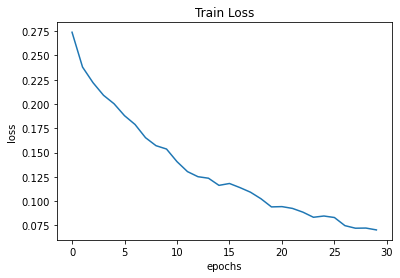

In [ ]:
plt.title('Train Loss')
plt.plot(total_train_loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

# Validation

nms_out is [0]
outputs is [{'boxes': tensor([[139.2771, 101.4887, 182.4634, 144.6953]], grad_fn=<CopyBackwards>), 'labels': tensor([1]), 'scores': tensor([0.9984], grad_fn=<CopyBackwards>)}, {'boxes': tensor([[121.8938,  51.1222, 198.5134, 128.0369]], grad_fn=<CopyBackwards>), 'labels': tensor([1]), 'scores': tensor([0.9973], grad_fn=<CopyBackwards>)}, {'boxes': tensor([[ 91.7580,  74.5195, 151.1260, 123.1003]], grad_fn=<CopyBackwards>), 'labels': tensor([1]), 'scores': tensor([0.9948], grad_fn=<CopyBackwards>)}, {'boxes': tensor([[198.8106,  29.6673, 294.7320,  99.2069],
        [262.3568,  85.2352, 298.6121, 154.0742],
        [241.6008,  30.2291, 295.2764,  92.2900],
        [248.8042,  41.6140, 297.8575, 145.7536]], grad_fn=<CopyBackwards>), 'labels': tensor([1, 1, 1, 1]), 'scores': tensor([0.9955, 0.6648, 0.2490, 0.0990], grad_fn=<CopyBackwards>)}]
box is [139 101 182 144]


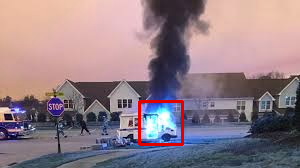

In [ ]:

# Validation of model 
model = torch.load(ROOT_DIR + 'fasterrcnn_resnet50_fpn.pth')

images_val, targets  = next(iter(test_data_loader)) # test_data_loader

images_val = list(img.to(device) for img in images_val)
# targets = [{k: v.to(device) for k,v in t.items()} for t in targets]
# print(f"target is {targets}")
# boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
sample_val = images_val[0].permute(1, 2, 0).cpu().numpy() # permute re-arrange the axes
sample_val = sample_val * 255. # de-normalize 

#get the bounding box from model
model.eval()
cpu_device = torch.device('cpu')

outputs = []
outputs = model(images_val)

# NMS 
nms_out = (torchvision.ops.nms(boxes= outputs[0]['boxes'], scores= outputs[0]['scores'], iou_threshold= 0.5)).cpu().numpy()
print(f"nms_out is {nms_out}")

outputs = [{k: v.to(cpu_device) for k,v in t.items()} for t in outputs]
print(f"outputs is {outputs}")
outs_val = outputs[nms_out[0]]['boxes'].cpu().detach().numpy().astype(np.int32)
# outs_val = outs_val[nms_out[0]]


for box in outs_val:
    print(f"box is {box}")
    cv2.rectangle(sample_val,
                #   (box, box),
                #   (box[2], box[3]),
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (0, 0, 225),
                  2
                  )


from google.colab.patches import cv2_imshow # https://github.com/jupyter/notebook/issues/3935
# image = cv2.rectangle(image, (xmin,ymin), (xmax, ymax), (0,0,225 ), 2)
cv2_imshow(sample_val);

array([139, 101, 182, 144], dtype=int32)